# Риск и распределение инвестиций в стартапы: расчёт объёма инвестиций

---

# Цель:
- Написать модель машинного обучения для:
    - рассчёта оптимального объёма инвестиций в стартап;
    - выявление признаков, влияющих на объём инвестиций;
    - сохранение модели для дальнейшего использования (расчёт объёма инвестиций).

In [106]:
import os
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = (8, 7)
%matplotlib inline
warnings.filterwarnings('ignore')

In [107]:
df = pd.read_csv('../data/processed/startup_investment_dataset+rejected_status.csv')

In [108]:
df = df[df['is_rejected'] == 0].drop(columns=['is_rejected', 'market_size_estimate'])
print(f'Общая длина: {len(df)} стартапов')
df.head()

Общая длина: 1948 стартапов


,startup_stage,industry,region,requested_amount,pre_money_valuation,team_size,founders_experience_years,annual_revenue,investment_amount
1,Series B,HealthTech,US,7.784759e+06,3.049307e+07,13,8,9.608746e+04,7.203092e+06
4,Series B,E-commerce,US,1.608484e+07,5.189190e+07,10,7,1.336527e+05,1.672645e+07
6,Seed,AI/SaaS,Europe,2.492487e+06,1.805700e+07,8,3,1.760057e+05,1.598191e+06
7,Series A,FinTech,US,7.464134e+06,3.169615e+07,11,5,1.219577e+06,4.706876e+06
8,Series A,AI/SaaS,US,3.152825e+06,2.375383e+07,9,2,1.266550e+05,2.755136e+06


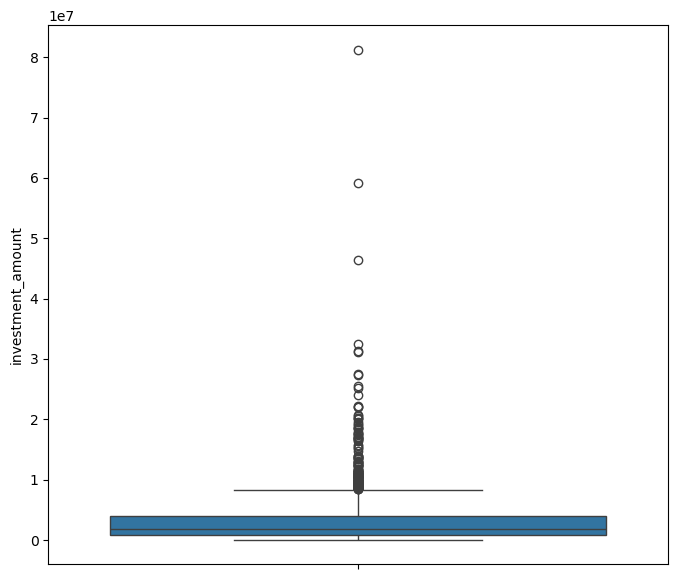

In [109]:
sns.boxplot(y=df['investment_amount'])
plt.show()

In [110]:
# Избавление от выбросов
q_low = df['investment_amount'].quantile(0.01)
q_high = df['investment_amount'].quantile(0.95)

df = df[(df['investment_amount'] >= q_low) & (df['investment_amount'] <= q_high)]

print(f'Отобрано {len(df)} стартапов с объёмом инвестиций от ${int(q_low):,} до ${int(q_high):,}.')

Отобрано 1830 стартапов с объёмом инвестиций от $137,361 до $10,043,519.


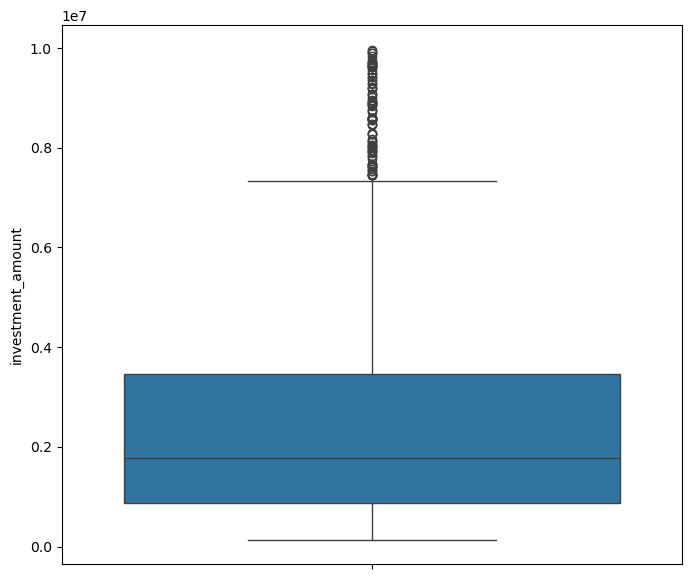

In [111]:
sns.boxplot(y=df['investment_amount'])
plt.show()

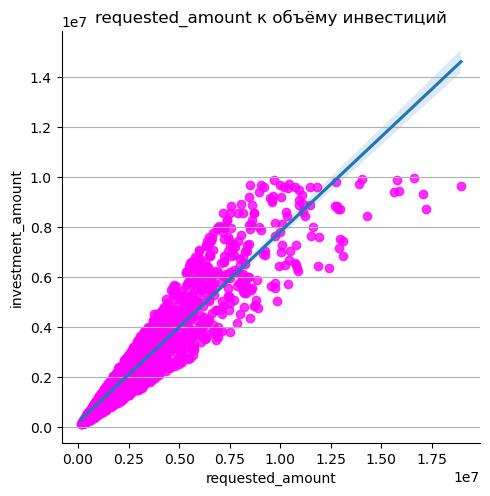

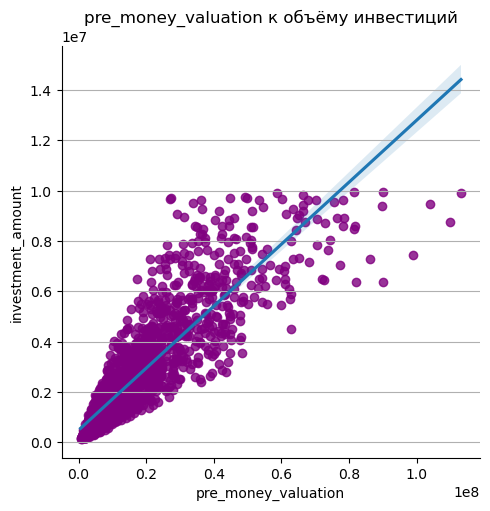

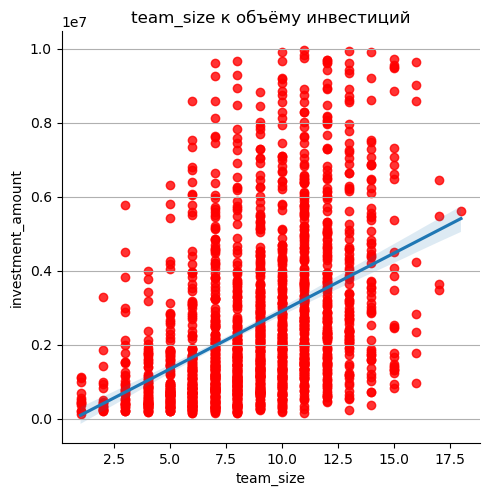

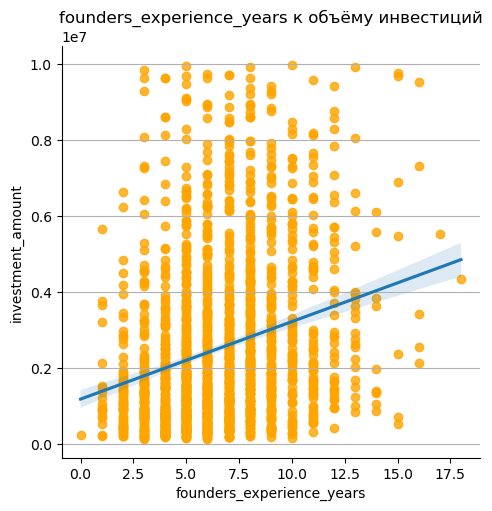

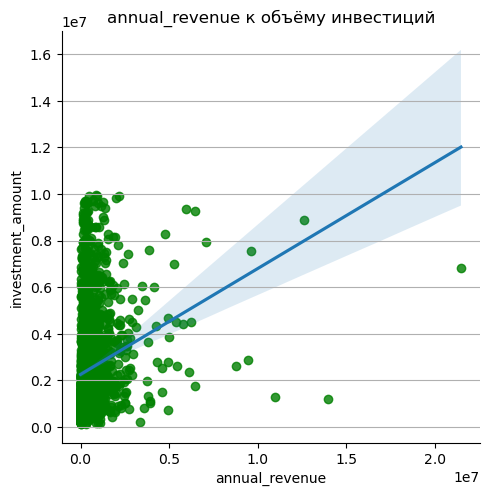

In [112]:
color_map = {
    'requested_amount': 'magenta',
    'team_size': 'red',
    'annual_revenue': 'green',
    'pre_money_valuation': 'purple',
    'founders_experience_years': 'orange'
}

for feature in df.select_dtypes(include=['int64', 'float64']).columns:
    if feature != 'investment_amount':
        sns.lmplot(
            data=df,
            x=feature,
            y='investment_amount',
            scatter_kws={'color': color_map.get(feature, 'gray')},
        )
        plt.grid(axis='y')
        plt.title(f'{feature} к объёму инвестиций')
        plt.show()

# Моделирование

In [113]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


## Логарифмирование целевой переменной
(Для меньшей чувствительности к выбросам)

In [114]:
df = df.loc[:, ~df.columns.str.endswith('_log_log')]

In [115]:
df['investment_amount_log'] = np.log1p(df['investment_amount'])

num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features.remove('investment_amount')
num_features.remove('investment_amount_log')  # таргет

for feature in num_features:
    df[f'{feature}_log'] = np.log1p(df[feature])

log_features = [col for col in df.columns if col.endswith('_log') and col != 'investment_amount_log']

# ВЕСА обратно пропорциональны логарифму
weights = 1 / np.log1p(df['investment_amount']) 

df.head()

,startup_stage,industry,region,requested_amount,pre_money_valuation,team_size,founders_experience_years,annual_revenue,investment_amount,investment_amount_log,requested_amount_log,pre_money_valuation_log,team_size_log,founders_experience_years_log,annual_revenue_log
1,Series B,HealthTech,US,7.784759e+06,3.049307e+07,13,8,9.608746e+04,7.203092e+06,15.790021,15.867678,17.233010,2.639057,2.197225,11.473025
6,Seed,AI/SaaS,Europe,2.492487e+06,1.805700e+07,8,3,1.760057e+05,1.598191e+06,14.284384,14.728792,16.709044,2.197225,1.386294,12.078277
7,Series A,FinTech,US,7.464134e+06,3.169615e+07,11,5,1.219577e+06,4.706876e+06,15.364535,15.825620,17.271706,2.484907,1.791759,14.014015
8,Series A,AI/SaaS,US,3.152825e+06,2.375383e+07,9,2,1.266550e+05,2.755136e+06,14.828978,14.963810,16.983255,2.302585,1.098612,11.749230
9,Seed,FinTech,US,2.722484e+06,1.256703e+07,8,8,3.605893e+05,1.459347e+06,14.193501,14.817056,16.346587,2.197225,2.197225,12.795498


In [116]:
target = 'investment_amount_log'
model_dir = '../src/models/interim'

In [117]:
def build_preprocessor(df, target):
    num_features = df.drop(columns=[target]).select_dtypes(include=['int64', 'float64']).columns
    cat_features = df.drop(columns=[target]).select_dtypes(include=['object']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), log_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), df.select_dtypes(include=['object']).columns.tolist())
        ]
    )

    return preprocessor, num_features, cat_features

In [118]:
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]

    return train_test_split(
        X, y,
        test_size=.2,
        random_state=42
    )

In [119]:
MODELS = {
    'ridge': (
        Ridge(random_state=42),
        {
            'model__alpha': [0.1, 1.0, 10.0]
        }
    ),
    'lasso': (
        Lasso(random_state=42),
        {
            'model__alpha': [0.01, 0.1, 1.0]
        }
    ),
    'random_forest': (
        RandomForestRegressor(random_state=42),
        {
            'model__n_estimators': [200, 500],
            'model__max_depth': [None, 10, 20]
        }
    ),
    'gboost': (
        GradientBoostingRegressor(random_state=42),
        {
            'model__n_estimators': [200, 500],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    ),
    'svr': (
        SVR(),
        {
            'model__C': [1, 10],
            'model__gamma': ['scale']
        }
    )
}

In [120]:
import joblib

In [121]:
def train_models(df, target):
    os.makedirs(model_dir, exist_ok=True)
    
    if 'investment_amount_log_log' in df.columns:
        df = df.drop(columns=['investment_amount_log_log'])

    # Разбиение
    X_train, X_test, y_train, y_test = split_data(df, target)

    # Препроцессинг
    preprocessor, _, _ = build_preprocessor(df, target)

    results = []

    for model_name, (model, param_grid) in MODELS.items():
        print(f'\n{model_name.upper()}')

        model_path = os.path.join(model_dir, f'{model_name}.joblib')

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Загрузка, если модель уже есть/обучение, если нет
        if os.path.exists(model_path):
            best_pipeline = joblib.load(model_path)
            print('Модель загружена.')
        else:
            print('Модель не обнаружена. Производится подбор гиперпараметров...')
            grid = GridSearchCV(
                pipeline,
                param_grid=param_grid,
                scoring='neg_root_mean_squared_error',
                cv=5,
                n_jobs=-1
            )

            grid.fit(X_train, y_train)
            best_pipeline = grid.best_estimator_

            joblib.dump(best_pipeline, model_path)
            print(f'Модель сохранена в: {model_path}')
            print(f'Лучшие гиперпараметры: {grid.best_params_}')

        y_pred = best_pipeline.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f'RMSE: {rmse:.3f} | R2: {r2:.3f}')

        # РЕЗУЛЬТАТЫ
        
        results.append({
            'model': model_name,
            'rmse': rmse,
            'r2': r2,
            'model_path': model_path
        })

    return pd.DataFrame(results).sort_values('rmse')

In [122]:
log_features = [col for col in df.columns if col.endswith('_log') and col != 'investment_amount_log']
log_features

['requested_amount_log',
 'pre_money_valuation_log',
 'team_size_log',
 'founders_experience_years_log',
 'annual_revenue_log']

In [123]:
results = train_models(df, target)
results


RIDGE
Модель загружена.
RMSE: 0.254 | R2: 0.930

LASSO
Модель загружена.
RMSE: 0.255 | R2: 0.929

RANDOM_FOREST


Модель загружена.
RMSE: 0.175 | R2: 0.967

GBOOST
Модель загружена.
RMSE: 0.230 | R2: 0.943

SVR
Модель загружена.
RMSE: 0.241 | R2: 0.937


,model,rmse,r2,model_path
2,random_forest,0.175179,0.966602,../src/models/interim\random_forest.joblib
3,gboost,0.229822,0.942517,../src/models/interim\gboost.joblib
4,svr,0.240741,0.936925,../src/models/interim\svr.joblib
0,ridge,0.253909,0.929836,../src/models/interim\ridge.joblib
1,lasso,0.255112,0.929170,../src/models/interim\lasso.joblib


# Лучшая модель: <span style='color:green'>_RandomForest_</span>

**Результаты на кросс-валидации:**
- RMSE = <span style='color:green'>0.175179</span>
- R^2 = <span style='color:green'>0.966602</span>

In [124]:
rf_pipeline = joblib.load('../src/models/interim/random_forest.joblib')

In [125]:
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = split_data(df, target)

In [126]:
y_pred = rf_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Метрики в лог-пространстве
print('Метрики в лог-пространстве:')
print(f'Log-RMSE = {rmse:.4f}')
print(f'Log-MAE = {mae:.4f}')
print(f'R2 = {r2:.4f}\n')

# Метрики в оригинальном масштабе (доллары)
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print('Метрики в долларах:')
print(f'MAE = ${mae_original:.0f}')
print(f'RMSE = ${rmse_original:.0f}')
print(f'MAPE = {mape:.1f}%')

print(f'\nИнтерпретация:')
print(f'1. В среднем, предсказание отклоняется на {mae_original:,.0f} $ от реальной суммы')
print(f'2. Ошибка составляет примерно {mape:.1f}% от реальных инвестиций')
print(f'3. Модель объясняет {r2:.1%} дисперсии в логарифме инвестиций')

Метрики в лог-пространстве:
Log-RMSE = 0.1752
Log-MAE = 0.1415
R2 = 0.9666

Метрики в долларах:
MAE = $363268
RMSE = $579173
MAPE = 14.6%

Интерпретация:
1. В среднем, предсказание отклоняется на 363,268 $ от реальной суммы
2. Ошибка составляет примерно 14.6% от реальных инвестиций
3. Модель объясняет 96.7% дисперсии в логарифме инвестиций


# Результаты RandomForest

| Метрика | Значение | Интерпретация                                                                                                               |
| ------- | -------- | -------- |
| Log-RMSE | 0.1752 | Среднеквадратичная ошибка в **лог-пространстве** низкая -> модель точно улавливает относительные различия между стартапами. |
| Log-MAE  | 0.1415 | Средняя абсолютная ошибка в логах небольшая -> большинство предсказаний близки к таргету. |
| R^2       | 0.9666 | Модель объясняет **96.7% вариации** лог-инвестиций -> порядок величины инвестиций предсказывается очень точно. |
| MAE      | $363,268 | В среднем предсказание отклоняется на __~363 тыс $__ от реальной суммы. |
| RMSE     | $579,173 | Среднеквадратичная ошибка в долларах отражает влияние крупных инвестиций, но в целом точность высока. |
| MAPE     | 14.6% | Ошибка составляет примерно 14.6% от реальных инвестиций — прогноз достаточно надёжный для практических решений. |

**Интерпретация:**  
1. В среднем предсказание отклоняется на $363k от реальной суммы, что делает прогноз оптимальным для ориентирования.  
2. Ошибка составляет ~14.6% от реальных инвестиций, подходя для стратегического планирования.  
3. RandomForest хорошо улавливает нелинейные зависимости между признаками и объёмом инвестиций, сохраняя высокое объяснение дисперсии в логарифме.

---

# Рекомендации по использованию модели

<span style='color:red'>**При использовании прогнозов RandomForest учитывать среднюю ошибку**:</span>
- **Прогноз = <u>predict ± $363,268**</u> — среднее отклонение для типичного стартапа.  
- Для особо крупных стартапов ошибка может быть больше (отражается в RMSE <u>**$579,173**</u>).</span> 
- Модель особенно надёжна для оценки **порядка величины и относительных различий** между стартапами.  
- При стратегическом планировании <span style='color: orange'><u>использовать прогноз как ориентир, а не как точную сумму сделки</u></span>.


In [130]:
try:
    joblib.dump(rf_pipeline, '../src/models/rf_regressor.joblib')
    print('Финальная модель сохранена в src/models/rf_regressor.joblib.')
except Exception as e:
    print(f'Не удалось сохранить модель:\n{e}')

Финальная модель сохранена в src/models/rf_regressor.joblib.
